In [40]:
# Module Import
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import random
import os

# 시드 고정 (재현성 확보)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cuda


# 데이터 불러오고 전처리

## 1. 데이터 통합 (`train_csv`, `normal_conversation.csv`)
- `idx` column 기준으로 인덱스를 이어서 붙혔다.

In [41]:
train_df = pd.read_csv('train.csv')
normal_df = pd.read_csv('normal_conversation.csv')
test_df = pd.read_csv('test.csv')

normal_df['idx'] = range(train_df['idx'].max() + 1, train_df['idx'].max() + 1 + len(normal_df))

normal_df = normal_df[['idx', 'class','conversation']]

train_df = pd.concat([train_df, normal_df], ignore_index = True)

train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
5211,5211,일반 대화,최근에 어떤 앱을 자주 사용해? 나는 운동 기록 앱을 사용하고 있어. 매일 운동극한...
5212,5212,일반 대화,을 사려고 하는데 추천 수 있나요?최근에 출시된 A모델이 좋다고 들었어요.감사합니다...
5213,5213,일반 대화,새 전자제품을 사려고 하는데 추천해주실 수 있나요? 최근에 출시된 A모델이 좋다고 ...
5214,5214,일반 대화,이번 주말에 친구들들신난다함께스릴 에 가기로 했어.타고정말 기대돼!많이놀이기구를 타...


음 . . 클래스 불균형은 딱히 없는 것 같다.
-> 근데 학습 시에 층화 추출로 이 균형이 안깨지게 분리 잘하기

In [42]:
train_df['class'].value_counts()

,count
class,
일반 대화,1266
기타 괴롭힘 대화,1094
갈취 대화,981
직장 내 괴롭힘 대화,979
협박 대화,896


## 2. 텍스트 클리닝
- 처음에 사용할 모델인 BERT.
- 개행 문자 `\n`을 공백으로 변경해 전체 대화를 하나의 문장으로 봐서 맥락 파악에 용이
- 근데 모델 입장에서 공백 1개 = 공백 2개 = 공백 3개 … 공백 개수는 무관하게 모두 공백 1개로 간주하니까 화자의 전환을 인식할 수 있는 규칙을 적용하자.  
- 먼저 `[SEP]` 특수 토큰을 활용해 화자 변환 시점을 구분하게 해줌.

In [43]:
def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)

    text = text.replace('\n', ' [SEP] ')

    return text

train_df['conversation'] = train_df['conversation'].apply(clean_text)

train_df['conversation'].sample(10)

,conversation
1897,저기 명현님 내일이 발표 날인데 왜 발표 자료 안 주시죠? [SEP] 제가 왜 줘야...
877,쟤 또 자랑한다. [SEP] 자랑 아니야. 난 너희에게 도움이 되는 정보를 주고 ...
4503,"수진아, 내일 발표 준비 다 됐어? 응, PPT는 완성했고 발표 연습 야. 분 발표..."
4725,"?회사는 ? 해줄에 뭐 이야은 할? 그거 ?. 생각난 에좋겠다물어볼게, 주말 교통 ..."
1595,강대리 당신 자리는 오늘부터 저기야 [SEP] 네.? 저기 몇 년간 사용 안 하던 ...
4709,동정 영화 봤어? 어떤 영화? 요즘 화제인 별의 노래. 아직 못 봤어. 재밌어? 정...
893,철수 씨는 그 학교 나와서 그 연봉 받고 살만해요? [SEP] 그게 무슨 말씀이시죠...
1292,넌 목소리가 왜 그래? 듣기 싫어. [SEP] 나도 내 목소리가 가끔 듣기 싫더라....
1168,야 틴트 좀 빌려줘 [SEP] 저번에 빌려간건.? [SEP] 아 그거 다썼는데 ? ...
1144,야 너네 집 고시원이라며? [SEP] 어어? 어. [SEP] 고시원이 이 차보다 ...


## 2. 레이블 정수 인코딩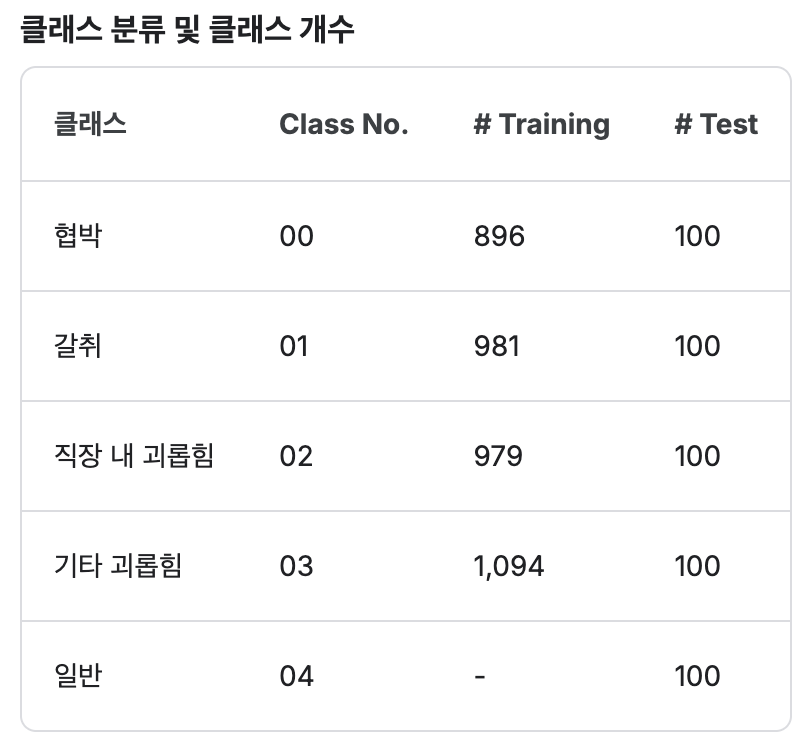


In [44]:
label_dict = {'협박 대화' : 0,
              '갈취 대화' : 1,
              '직장 내 괴롭힘 대화' : 2,
              '기타 괴롭힘 대화' : 3,
              '일반 대화' : 4}

train_df['class'] = train_df['class'].map(label_dict)
train_df['class']

,class
0,0
1,0
2,3
3,1
4,1
...,...
5211,4
5212,4
5213,4
5214,4


BERT가 인식할 수 있는 최대 문장 길이를 고려해 학습 데이터 문장의 길이 지표도 확인
- `Max_length`를 256으로 설정하고 모델 개선시 조정해보기

In [45]:
stat_df = train_df.copy()

stat_df['char_len'] = stat_df['conversation'].str.len()
stat_df['count_word'] = stat_df['conversation'].str.split().str.len()

stats = stat_df[['char_len', 'count_word']].describe(percentiles=[0.5,0.75,0.9,0.95,0.99])
stats

,char_len,count_word
count,5216.000000,5216.000000
mean,259.528183,62.287577
std,113.236118,28.788336
min,28.000000,7.000000
50%,242.000000,57.000000
75%,312.000000,75.000000
90%,393.000000,95.000000
95%,465.500000,115.000000
99%,655.850000,167.850000
max,940.000000,240.000000


훈련/검증 데이터 분리

In [46]:
# from sklearn.model_selection import train_test_split

# train, val = train_test_split(train_df,
#                               test_size=0.1,
#                               random_state=42,
#                               stratify = train_df['class'])

## 4. 토크나이저
- Hugging Face 라이브러리를 이용해 BERT 모델 토크나이저 불러오기
- 맨 처음 기본 BERT 모델 사용

In [47]:
from transformers import AutoTokenizer

model_name = "klue/bert-base" # 모델 교체 시 이 부분 사용 최고의 성능 : "klue/bert-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

PyTorch 를 이용
- 우선 데이터셋 클래스를 정의

In [48]:
class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=384):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            add_special_tokens=True
        )

        item = {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0]
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])

        return item

In [49]:
train_dataset = ConversationDataset(
    train['conversation'].tolist(),
    train['class'].values,
    tokenizer
)
val_dataset = ConversationDataset(
    val['conversation'].tolist(),
    val['class'].values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [50]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

In [53]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

epochs = 3
best_score = 0.0
best_model_path = "best_model.pt"

for epoch in range(epochs):
    model.train()
    total_loss = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in train_loader:

        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**inputs)
        loss = outputs.loss

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs['labels'].cpu().numpy()

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels)

    val_acc = accuracy_score(val_true, val_preds)
    val_f1 = f1_score(val_true, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{epochs}")
    print(f" - Train Loss : {avg_train_loss:.4f}")
    print(f" - Val Acc : {val_acc:.4f}")
    print(f" - F1-Score : {val_f1:.4f}")

    if val_f1 > best_score:
        best_score = val_f1
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Best model saved! (Acc : {best_score : .4f})")
    print("-"* 30)

Epoch 1/3:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1/3
 - Train Loss : 0.1065
 - Val Acc : 0.9310
 - F1-Score : 0.9289
Best model saved! (Acc :  0.9289)
------------------------------


Epoch 2/3:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2/3
 - Train Loss : 0.0708
 - Val Acc : 0.9406
 - F1-Score : 0.9369
Best model saved! (Acc :  0.9369)
------------------------------


Epoch 3/3:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3/3
 - Train Loss : 0.0345
 - Val Acc : 0.9349
 - F1-Score : 0.9332
------------------------------


In [54]:
# 테스트 데이터셋 생성
test_dataset = ConversationDataset(
    test_df['conversation'].tolist(),
    labels=None,
    tokenizer=tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 최고 성능 모델 로드
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

# 추론
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().tolist()
        predictions.extend(preds)

# 결과 저장
submission = pd.DataFrame({
    'idx': test_df['idx'],
    'target': predictions
})

submission.to_csv('submission.csv', index=False)
print("submission.csv 생성 완료!")

submission.csv 생성 완료!


In [57]:
import pandas as pd
import numpy as np
import re
import torch
import gc
import os
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ==========================================
# 1. 설정 및 시드 고정
# ==========================================
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# ★ 사용자 설정 반영 ★
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 16  # 256 길이면 16~32 가능 (OOM 나면 8로 줄이세요)
EPOCHS = 3
N_SPLITS = 5     # 5-Fold 교차 검증

# ==========================================
# 2. 데이터 로드 및 전처리
# ==========================================
train_df = pd.read_csv('train.csv')
normal_df = pd.read_csv('normal_conversation.csv') # 파일이 없다면 이 부분 제외
# test_df = pd.read_csv('test.csv') # 추론 때 사용

# 일반 대화 데이터 통합
normal_df['idx'] = range(train_df['idx'].max() + 1, train_df['idx'].max() + 1 + len(normal_df))
normal_df = normal_df[['idx', 'class', 'conversation']]
train_df = pd.concat([train_df, normal_df], ignore_index=True)

# 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text

train_df['conversation'] = train_df['conversation'].apply(clean_text)

# 레이블 인코딩
label_dict = {
    '협박 대화': 0, '갈취 대화': 1, '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3, '일반 대화': 4
}
train_df['class'] = train_df['class'].map(label_dict)

# ==========================================
# 3. 데이터셋 클래스 정의
# ==========================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            add_special_tokens=True
        )

        item = {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0]
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# ==========================================
# 4. Stratified K-Fold 학습 루프
# ==========================================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 전체 데이터 준비
X = train_df['conversation'].tolist()
y = train_df['class'].values

print(f"🚀 학습 시작! (Model: {MODEL_NAME}, Len: {MAX_LEN}, 5-Fold)")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n================ [Fold {fold+1}/{N_SPLITS}] ================")

    # Fold별 데이터 분할
    train_texts = [X[i] for i in train_idx]
    train_labels = y[train_idx]
    val_texts = [X[i] for i in val_idx]
    val_labels = y[val_idx]

    # 데이터셋 생성
    train_ds = ConversationDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds = ConversationDataset(val_texts, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # 모델 초기화 (매 Fold마다 새로 생성해야 함)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
    model.to(device)

    # Optimizer & Scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * 0.1),
        num_training_steps=total_steps
    )
    scaler = GradScaler() # FP16 사용

    # 학습 루프
    best_f1 = 0.0

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0

        # tqdm으로 진행률 표시
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in loop:
            optimizer.zero_grad()

            with autocast():
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item()) # 실시간 Loss 표시

        avg_loss = train_loss / len(train_loader)

        # 검증 (Validation)
        model.eval()
        val_preds, val_true = [], []

        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                with autocast():
                    outputs = model(**inputs)

                preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(inputs['labels'].cpu().numpy())

        # 성능 평가 (F1 Score)
        val_acc = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds, average='macro')

        print(f"  - Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Fold별 최고 모델 저장
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
            print(f"  -> Best Model Saved! (Fold {fold+1})")

    # 메모리 정리
    del model, optimizer, scheduler, scaler
    gc.collect()
    torch.cuda.empty_cache()

print("\n🎉 모든 Fold 학습 완료!")

사용 장치: cuda
🚀 학습 시작! (Model: klue/bert-base, Len: 256, 5-Fold)

================ [Fold 1/5] ================


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.5295 | Val Acc: 0.8985 | Val F1: 0.8942
  -> Best Model Saved! (Fold 1)


Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.1333 | Val Acc: 0.9100 | Val F1: 0.9059
  -> Best Model Saved! (Fold 1)


Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.0415 | Val Acc: 0.9186 | Val F1: 0.9148
  -> Best Model Saved! (Fold 1)

================ [Fold 2/5] ================


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.5086 | Val Acc: 0.9166 | Val F1: 0.9124
  -> Best Model Saved! (Fold 2)


Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.1463 | Val Acc: 0.9310 | Val F1: 0.9274
  -> Best Model Saved! (Fold 2)


Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.0482 | Val Acc: 0.9396 | Val F1: 0.9361
  -> Best Model Saved! (Fold 2)

================ [Fold 3/5] ================


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.5107 | Val Acc: 0.8984 | Val F1: 0.8935
  -> Best Model Saved! (Fold 3)


Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.1476 | Val Acc: 0.9348 | Val F1: 0.9308
  -> Best Model Saved! (Fold 3)


Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.0469 | Val Acc: 0.9406 | Val F1: 0.9372
  -> Best Model Saved! (Fold 3)

================ [Fold 4/5] ================


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.5184 | Val Acc: 0.9022 | Val F1: 0.8967
  -> Best Model Saved! (Fold 4)


Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.1590 | Val Acc: 0.9329 | Val F1: 0.9292
  -> Best Model Saved! (Fold 4)


Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.0495 | Val Acc: 0.9367 | Val F1: 0.9334
  -> Best Model Saved! (Fold 4)

================ [Fold 5/5] ================


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.5211 | Val Acc: 0.9195 | Val F1: 0.9156
  -> Best Model Saved! (Fold 5)


Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.1398 | Val Acc: 0.9310 | Val F1: 0.9277
  -> Best Model Saved! (Fold 5)


Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2790140553.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2790140553.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  - Train Loss: 0.0487 | Val Acc: 0.9338 | Val F1: 0.9303
  -> Best Model Saved! (Fold 5)

🎉 모든 Fold 학습 완료!


In [68]:
# 테스트 데이터셋 생성
test_dataset = ConversationDataset(
    test_df['conversation'].tolist(),
    labels=None,
    tokenizer=tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model.to(device)

# 최고 성능 모델 로드
model.load_state_dict(torch.load('best_model_fold5.pt'))
model.to(device)
model.eval()

# 추론
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().tolist()
        predictions.extend(preds)

# 결과 저장
submission = pd.DataFrame({
    'idx': test_df['idx'],
    'target': predictions
})

submission.to_csv('submission_fold5.csv', index=False)
print("submission.csv 생성 완료!")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

submission.csv 생성 완료!


5-fold별 베스트 모델 생성

In [69]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
from tqdm.auto import tqdm
import gc

# 1. 설정 (학습 때와 동일하게 맞춰야 함)
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 32 # 추론은 메모리를 적게 쓰므로 32도 넉넉함 (RTX 3060 기준)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# 2. 데이터 로드 및 전처리
test_df = pd.read_csv('test.csv')

def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text

print("테스트 데이터 전처리 중...")
test_df['conversation'] = test_df['conversation'].apply(clean_text)

# 3. 데이터셋 클래스 및 로더 정의
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            add_special_tokens=True
        )

        item = {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0]
        }
        return item

test_dataset = ConversationDataset(test_df['conversation'].tolist(), labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. 앙상블 및 개별 추론 시작
# 최종 결과를 누적할 변수 (Test 데이터 개수 x 클래스 5개)
ensemble_logits = np.zeros((len(test_df), 5))

print(f"🚀 5-Fold 앙상블 추론 시작!")

for fold in range(1, 6): # 1~5까지 반복
    print(f"\n[Fold {fold}] 모델 로드 및 추론 중...")

    # 해당 Fold의 모델 불러오기
    model_path = f"best_model_fold{fold}.pt"
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    fold_logits_list = []

    # 추론 수행
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Fold {fold} Predicting"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            # 결과값(Logits)을 CPU로 가져와서 리스트에 저장
            logits = outputs.logits.cpu().numpy()
            fold_logits_list.append(logits)

    # 리스트를 하나의 Numpy 배열로 합치기
    fold_logits = np.concatenate(fold_logits_list, axis=0)

    # ---------------------------------------------------------
    # [개별 파일 생성] Fold별 Submission 저장
    # ---------------------------------------------------------
    fold_preds = np.argmax(fold_logits, axis=1) # 가장 높은 확률의 인덱스 추출

    fold_submission = pd.DataFrame({
        'idx': test_df['idx'],
        'target': fold_preds
    })
    fold_file_name = f'submission_fold{fold}.csv'
    fold_submission.to_csv(fold_file_name, index=False)
    print(f"  -> {fold_file_name} 저장 완료!")

    # ---------------------------------------------------------
    # [앙상블 누적] 최종 결과에 더하기
    # ---------------------------------------------------------
    ensemble_logits += fold_logits

    # 메모리 정리 (중요: GPU 메모리 확보)
    del model
    torch.cuda.empty_cache()

# 5. 최종 앙상블 결과 생성
print("\n📊 앙상블 결과 계산 중...")

# 5개 모델의 합계를 5로 나누어 평균 계산 (Soft Voting)
avg_logits = ensemble_logits / 5
final_predictions = np.argmax(avg_logits, axis=1)

# 최종 파일 저장
final_submission = pd.DataFrame({
    'idx': test_df['idx'],
    'target': final_predictions
})

final_submission.to_csv('submission_ensemble.csv', index=False)
print("🎉 모든 작업 완료! 'submission_ensemble.csv' 생성됨.")

사용 장치: cuda
테스트 데이터 전처리 중...
🚀 5-Fold 앙상블 추론 시작!

[Fold 1] 모델 로드 및 추론 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Fold 1 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

  -> submission_fold1.csv 저장 완료!

[Fold 2] 모델 로드 및 추론 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Fold 2 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

  -> submission_fold2.csv 저장 완료!

[Fold 3] 모델 로드 및 추론 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Fold 3 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

  -> submission_fold3.csv 저장 완료!

[Fold 4] 모델 로드 및 추론 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Fold 4 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

  -> submission_fold4.csv 저장 완료!

[Fold 5] 모델 로드 및 추론 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Fold 5 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

  -> submission_fold5.csv 저장 완료!

📊 앙상블 결과 계산 중...
🎉 모든 작업 완료! 'submission_ensemble.csv' 생성됨.


상위 3개 모델만 앙상블 해보기

In [70]:
import pandas as pd
from collections import Counter

# 1. 성능이 좋았던 상위 3개 Fold 파일만 선택 (Fold 2, 3, 4)
files = [
    'submission_fold2.csv', # 0.776 (에이스)
    'submission_fold3.csv', # 0.736
    'submission_fold4.csv'  # 0.740
]

# 데이터프레임 읽기
dfs = [pd.read_csv(f) for f in files]

# 2. 다수결 투표 (Hard Voting) 함수
def hard_voting(row_idx):
    # 각 모델이 예측한 값들을 모음
    predictions = [df.iloc[row_idx]['target'] for df in dfs]

    # 가장 많이 등장한 값(최빈값) 찾기
    # 예: [1, 1, 2] -> 1 선택
    most_common = Counter(predictions).most_common(1)[0][0]
    return most_common

# 3. 모든 데이터에 대해 투표 진행
final_preds = [hard_voting(i) for i in range(len(dfs[0]))]

# 4. 결과 저장
submission = pd.DataFrame({
    'idx': dfs[0]['idx'],
    'target': final_preds
})

submission.to_csv('final_best_ensemble.csv', index=False)
print("🎉 상위 3개 모델 다수결 앙상블 완료! 'final_best_ensemble.csv' 생성됨.")

🎉 상위 3개 모델 다수결 앙상블 완료! 'final_best_ensemble.csv' 생성됨.


시드 앙상블

In [71]:
import pandas as pd
import numpy as np
import torch
import gc
import os
import random
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ==========================================
# 1. 설정 (BERT-base, Fold 2 타겟팅)
# ==========================================
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
TARGET_FOLD = 2  # 0.776이 나왔던 그 Fold 번호 (1부터 시작하는 번호 기준)
SEEDS = [42, 43, 44] # 시드 3대장

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 준비 (Fold 2만 추출)
# ==========================================
# (데이터 로드 및 clean_text 함수는 기존과 동일하다고 가정)
# train_df, tokenizer 등은 메모리에 있다고 가정하고 진행합니다.

# 혹시 몰라 데이터 로드 부분만 다시 명시
train_df = pd.read_csv('train.csv')
normal_df = pd.read_csv('normal_conversation.csv')
normal_df['idx'] = range(train_df['idx'].max() + 1, train_df['idx'].max() + 1 + len(normal_df))
normal_df = normal_df[['idx', 'class', 'conversation']]
train_df = pd.concat([train_df, normal_df], ignore_index=True)

# 전처리
import re
def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text
train_df['conversation'] = train_df['conversation'].apply(clean_text)
label_dict = {'협박 대화':0, '갈취 대화':1, '직장 내 괴롭힘 대화':2, '기타 괴롭힘 대화':3, '일반 대화':4}
train_df['class'] = train_df['class'].map(label_dict)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# StratifiedKFold로 Fold 2의 인덱스 찾기
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 이 random_state는 고정!!
X = train_df['conversation'].tolist()
y = train_df['class'].values

# Fold 2의 인덱스만 추출 (idx=1이 두 번째 폴드)
for fold_idx, (t_idx, v_idx) in enumerate(skf.split(X, y)):
    if fold_idx == (TARGET_FOLD - 1): # Fold 2를 찾음
        train_indices = t_idx
        val_indices = v_idx
        break

print(f"🎯 황금 데이터셋(Fold {TARGET_FOLD}) 확보 완료!")

# 데이터셋 정의
class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=self.max_len, padding='max_length', add_special_tokens=True)
        return {'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0], 'labels': torch.tensor(self.labels[idx], dtype=torch.long)}

# ==========================================
# 3. 시드 루프 학습 (Seed 42, 43, 44)
# ==========================================
print(f"🚀 Fold {TARGET_FOLD} 기반 Seed Ensemble 시작! (Seeds: {SEEDS})")

for seed in SEEDS:
    print(f"\n🌱 [Seed {seed}] 학습 시작...")

    # ★ 핵심: 시드 변경 ★
    def seed_everything(seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    seed_everything(seed)

    # 데이터셋 & 로더 생성 (데이터 구성은 항상 똑같음)
    train_ds = ConversationDataset([X[i] for i in train_indices], y[train_indices], tokenizer, MAX_LEN)
    val_ds = ConversationDataset([X[i] for i in val_indices], y[val_indices], tokenizer, MAX_LEN)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # 모델 초기화
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(len(train_loader)*EPOCHS*0.1), num_training_steps=len(train_loader)*EPOCHS)
    scaler = GradScaler()

    best_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}")
        for batch in loop:
            optimizer.zero_grad()
            with autocast():
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            loop.set_postfix(loss=loss.item())

        # 검증 (Validation)
        model.eval()
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                with autocast(): outputs = model(**inputs)
                preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
                true_labels.extend(inputs['labels'].cpu().numpy())

        # 정확도 체크
        from sklearn.metrics import accuracy_score
        val_acc = accuracy_score(true_labels, preds)
        print(f"  Seed {seed} - Ep {epoch+1} Acc: {val_acc:.4f}")

        # 시드별 최고 모델 저장
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_seed{seed}.pt")

    print(f"✅ Seed {seed} 완료! Best Acc: {best_acc:.4f}")
    del model, optimizer, scheduler, scaler
    gc.collect()
    torch.cuda.empty_cache()

print("🎉 시드 앙상블 학습 완료!")

🎯 황금 데이터셋(Fold 2) 확보 완료!
🚀 Fold 2 기반 Seed Ensemble 시작! (Seeds: [42, 43, 44])

🌱 [Seed 42] 학습 시작...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Ep 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 42 - Ep 1 Acc: 0.9147


Ep 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 42 - Ep 2 Acc: 0.9329


Ep 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 42 - Ep 3 Acc: 0.9319
✅ Seed 42 완료! Best Acc: 0.9329

🌱 [Seed 43] 학습 시작...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Ep 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 43 - Ep 1 Acc: 0.9204


Ep 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 43 - Ep 2 Acc: 0.9377


Ep 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 43 - Ep 3 Acc: 0.9396
✅ Seed 43 완료! Best Acc: 0.9396

🌱 [Seed 44] 학습 시작...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Ep 1:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 44 - Ep 1 Acc: 0.9147


Ep 2:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 44 - Ep 2 Acc: 0.9291


Ep 3:   0%|          | 0/261 [00:00<?, ?it/s]

/tmp/ipython-input-2239979492.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2239979492.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(**inputs)


  Seed 44 - Ep 3 Acc: 0.9406
✅ Seed 44 완료! Best Acc: 0.9406
🎉 시드 앙상블 학습 완료!


In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import gc

# 1. 설정
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 32
SEEDS = [42, 43, 44] # 학습시킨 시드 리스트
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터셋 클래스 (수정됨: labels가 없으면 건너뛰도록 변경) ⭐️ 중요
class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            add_special_tokens=True
        )

        item = {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0]
        }

        # ⭐️ 수정된 부분: 레이블이 있을 때만 처리
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# 3. 테스트 데이터 로드 및 전처리
test_df = pd.read_csv('test.csv')

def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text

print("데이터 전처리 중...")
test_df['conversation'] = test_df['conversation'].apply(clean_text)

# 토크나이저 및 데이터셋 생성
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_ds = ConversationDataset(test_df['conversation'].tolist(), labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# 4. 시드 앙상블 추론
final_logits = np.zeros((len(test_df), 5))

print(f"🚀 시드 앙상블 추론 시작! (Seeds: {SEEDS})")

for seed in SEEDS:
    print(f"\nLoad Model Seed {seed}...")

    # 모델 초기화 (이때 뜨는 MISSING/UNEXPECTED 로그는 정상이니 무시하세요!)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

    # 학습된 가중치 덮어쓰기
    try:
        model.load_state_dict(torch.load(f"best_model_seed{seed}.pt"))
    except FileNotFoundError:
        print(f"⚠️ 경고: best_model_seed{seed}.pt 파일을 찾을 수 없습니다. 이 시드는 건너뜁니다.")
        continue

    model.to(device)
    model.eval()

    seed_logits = []

    with torch.no_grad():
        # tqdm 에러 방지를 위해 단순 반복문 사용 가능하지만, 여기선 수정된 데이터셋 덕분에 잘 될 겁니다.
        for batch in tqdm(test_loader, desc=f"Seed {seed} Predicting"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            seed_logits.extend(outputs.logits.cpu().numpy())

    final_logits += np.array(seed_logits)

    # 메모리 정리
    del model
    torch.cuda.empty_cache()

# 5. 결과 저장
if len(SEEDS) > 0:
    final_preds = np.argmax(final_logits / len(SEEDS), axis=1)

    sub = pd.DataFrame({'idx': test_df['idx'], 'target': final_preds})
    sub.to_csv('submission_seed_ensemble.csv', index=False)
    print("\n🏆 축하합니다! 최종 파일 생성 완료: submission_seed_ensemble.csv")
else:
    print("\n❌ 처리된 시드가 없습니다.")

데이터 전처리 중...
🚀 시드 앙상블 추론 시작! (Seeds: [42, 43, 44])

Load Model Seed 42...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Seed 42 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Load Model Seed 43...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Seed 43 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Load Model Seed 44...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Seed 44 Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


🏆 축하합니다! 최종 파일 생성 완료: submission_seed_ensemble.csv


Pseudo-Labeling

마지막1. 나온 모델로 재추론만하기

In [82]:
import pandas as pd
import numpy as np
import torch
import gc
import re
import os
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import torch.nn.functional as F

# ==========================================
# 1. 설정 (RTX 3060 최적화)
# ==========================================
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 4
CONFIDENCE_THRESHOLD = 0.70  # 90% 이상 확신하는 데이터만 추가 (안전빵)
TEACHER_MODEL_PATH = "best_model_pseudo.pt"  # 가장 성능 좋았던 모델 파일명

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# ==========================================
# 2. 데이터 전처리 함수 & 클래스
# ==========================================
def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ConversationDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text, return_tensors='pt', truncation=True, max_length=self.max_len, padding='max_length', add_special_tokens=True
        )
        item = {'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0]}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# ==========================================
# 3. [Teacher] 테스트 데이터 추론 및 가짜 라벨 생성
# ==========================================
print(f"👨‍🏫 Teacher Model({TEACHER_MODEL_PATH}) 로딩 중...")

# 테스트 데이터 로드
test_df = pd.read_csv('test.csv')
test_df['conversation'] = test_df['conversation'].apply(clean_text)
test_ds = ConversationDataset(test_df['conversation'].tolist(), labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model.load_state_dict(torch.load(TEACHER_MODEL_PATH))
model.to(device)
model.eval()

pseudo_data = []
pseudo_labels = []

print("🎯 고확신 데이터(Pseudo-Label) 선별 중...")

with torch.no_grad():
    for batch, original_text in zip(tqdm(test_loader, desc="Filtering"), test_df['conversation'].tolist()):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)

        # 확률 계산 (Softmax)
        probs = F.softmax(outputs.logits, dim=-1)
        max_probs, preds = torch.max(probs, dim=-1)

        # 임계값 넘는 데이터만 추출
        max_probs = max_probs.cpu().numpy()
        preds = preds.cpu().numpy()

        # 배치 내에서 조건 만족하는 인덱스 찾기
        start_idx = len(pseudo_data) # 현재까지 쌓인 데이터 수 (단순 카운팅용 아님, 로직 주의)
        # 배치를 순회하며 필터링
        # (Dataset 구조상 text를 배치 단위로 가져오기 까다로우므로, test_df 전체 리스트를 슬라이싱해서 씁니다)
        pass

    # 위 방식보다 더 안전하게 다시 짭니다. (인덱스 꼬임 방지)

# --- [수정] 안전한 필터링 로직 ---
test_probs = []
test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        test_probs.extend(probs.cpu().numpy())

test_probs = np.array(test_probs)
max_conf = np.max(test_probs, axis=1) # 가장 높은 확률값
final_preds = np.argmax(test_probs, axis=1) # 예측 라벨

# 필터링
indices = np.where(max_conf >= CONFIDENCE_THRESHOLD)[0]
filtered_texts = test_df.loc[indices, 'conversation'].tolist()
filtered_labels = final_preds[indices]

print(f"✅ 전체 {len(test_df)}개 중 {len(indices)}개 ({len(indices)/len(test_df)*100:.1f}%) 데이터 추가 확보!")
print(f"   -> 이 데이터들이 학습 데이터에 추가됩니다.")

del model
torch.cuda.empty_cache()

# ==========================================
# 4. 데이터 병합 (Original + Pseudo)
# ==========================================
# 원본 학습 데이터 로드
train_df = pd.read_csv('train.csv')
normal_df = pd.read_csv('normal_conversation.csv')
normal_df['idx'] = range(train_df['idx'].max() + 1, train_df['idx'].max() + 1 + len(normal_df))
normal_df = normal_df[['idx', 'class', 'conversation']]
train_df = pd.concat([train_df, normal_df], ignore_index=True)

train_df['conversation'] = train_df['conversation'].apply(clean_text)
label_dict = {'협박 대화':0, '갈취 대화':1, '직장 내 괴롭힘 대화':2, '기타 괴롭힘 대화':3, '일반 대화':4}
train_df['class'] = train_df['class'].map(label_dict)

# 병합
X_train = train_df['conversation'].tolist() + filtered_texts
y_train = np.concatenate([train_df['class'].values, filtered_labels])

print(f"📊 최종 학습 데이터 개수: {len(X_train)}개 (기존 {len(train_df)} + 추가 {len(filtered_texts)})")

# ==========================================
# 5. [Student] 모델 재학습 (전체 데이터 사용)
# ==========================================
print("🚀 확장된 데이터로 모델 재학습 시작 (Validation 없이 Full Training)")

# 전체 데이터를 다 씁니다 (검증셋 X -> 리더보드 점수 극대화용)
train_ds = ConversationDataset(X_train, y_train, tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps*0.1), num_training_steps=total_steps)
scaler = GradScaler()

for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(train_loader, desc=f"Ep {epoch+1}")
    total_loss = 0

    for batch in loop:
        optimizer.zero_grad()
        with autocast():
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Ep {epoch+1} Avg Loss: {total_loss / len(train_loader):.4f}")

# 모델 저장 (선택)
torch.save(model.state_dict(), "best_model_final.pt")
print("💾 재학습 완료! 모델 저장됨.")

# ==========================================
# 6. 최종 추론 및 제출 파일 생성
# ==========================================
print("🏁 최종 테스트 데이터 추론 중...")
model.eval()
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False) # 테스트셋 다시 로드

final_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Inference"):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        final_preds.extend(preds)

submission = pd.DataFrame({'idx': test_df['idx'], 'target': final_preds})
submission.to_csv('submission_final.csv', index=False)

print("\n🎉 모든 작업 완료! 'submission_final.csv' 제출 준비 끝!")

👨‍🏫 Teacher Model(best_model_pseudo.pt) 로딩 중...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

🎯 고확신 데이터(Pseudo-Label) 선별 중...


Filtering:   0%|          | 0/16 [00:00<?, ?it/s]

Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

✅ 전체 500개 중 483개 (96.6%) 데이터 추가 확보!
   -> 이 데이터들이 학습 데이터에 추가됩니다.
📊 최종 학습 데이터 개수: 5699개 (기존 5216 + 추가 483)
🚀 확장된 데이터로 모델 재학습 시작 (Validation 없이 Full Training)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Ep 1:   0%|          | 0/357 [00:00<?, ?it/s]

/tmp/ipython-input-1181644917.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 1 Avg Loss: 0.5159


Ep 2:   0%|          | 0/357 [00:00<?, ?it/s]

Ep 2 Avg Loss: 0.1628


Ep 3:   0%|          | 0/357 [00:00<?, ?it/s]

Ep 3 Avg Loss: 0.0455


Ep 4:   0%|          | 0/357 [00:00<?, ?it/s]

Ep 4 Avg Loss: 0.0183
💾 재학습 완료! 모델 저장됨.
🏁 최종 테스트 데이터 추론 중...


Final Inference:   0%|          | 0/16 [00:00<?, ?it/s]


🎉 모든 작업 완료! 'submission_final.csv' 제출 준비 끝!


In [78]:
# 0.796 점수 나온 모델 파일명으로 수정하세요
BEST_PSEUDO_MODEL = "best_model_pseudo.pt"

print("🚀 TTA(Test Time Augmentation) 추론 시작...")

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model.load_state_dict(torch.load(BEST_PSEUDO_MODEL))
model.to(device)
model.eval()

# 데이터셋 로드 (기존과 동일)
test_df = pd.read_csv('test.csv')
test_df['conversation'] = test_df['conversation'].apply(clean_text) # 전처리

# --- TTA 추론 ---
final_logits = np.zeros((len(test_df), 5))

# 1. 원본 예측
print("1️⃣ 원본 데이터 예측 중...")
test_ds = ConversationDataset(test_df['conversation'].tolist(), labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
loader = DataLoader(test_ds, batch_size=32, shuffle=False)
with torch.no_grad():
    logits_1 = []
    for batch in tqdm(loader):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        logits_1.extend(outputs.logits.cpu().numpy())
    final_logits += np.array(logits_1)

# 2. 변형 데이터 예측 (앞뒤에 공백 추가) - 미세한 변화를 줌
print("2️⃣ 변형 데이터(공백 추가) 예측 중...")
# 텍스트 앞뒤에 공백을 추가해서 토큰화가 미세하게 달라지게 유도
aug_texts = [" " + t + " " for t in test_df['conversation'].tolist()]
test_ds_aug = ConversationDataset(aug_texts, labels=None, tokenizer=tokenizer, max_len=MAX_LEN)
loader_aug = DataLoader(test_ds_aug, batch_size=32, shuffle=False)
with torch.no_grad():
    logits_2 = []
    for batch in tqdm(loader_aug):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        logits_2.extend(outputs.logits.cpu().numpy())
    final_logits += np.array(logits_2)

# 평균 내기
final_preds = np.argmax(final_logits / 2, axis=1)

# 저장
submission = pd.DataFrame({'idx': test_df['idx'], 'target': final_preds})
submission.to_csv('submission_tta.csv', index=False)
print("🎉 TTA 완료! 'submission_tta.csv' 생성됨.")

🚀 TTA(Test Time Augmentation) 추론 시작...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

1️⃣ 원본 데이터 예측 중...


  0%|          | 0/16 [00:00<?, ?it/s]

2️⃣ 변형 데이터(공백 추가) 예측 중...


  0%|          | 0/16 [00:00<?, ?it/s]

🎉 TTA 완료! 'submission_tta.csv' 생성됨.


fold2 + pseudo

In [79]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
from tqdm.auto import tqdm

# ==========================================
# 1. 설정
# ==========================================
MODEL_NAME = "klue/bert-base"
MAX_LEN = 256
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 파일 경로 (반드시 이 파일들이 있어야 합니다)
MODEL_A_PATH = "best_model_fold2.pt"   # 0.776 (정석)
MODEL_B_PATH = "best_model_pseudo.pt"  # 0.796 (괴물)

# ⭐️ 핵심: 가중치 배합 (괴물 7 : 정석 3)
WEIGHT_A = 0.3
WEIGHT_B = 0.7

# ==========================================
# 2. 데이터셋 준비
# ==========================================
test_df = pd.read_csv('test.csv')

def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9?!\.,\s]', '', text)
    text = text.replace('\n', ' [SEP] ')
    return text

test_df['conversation'] = test_df['conversation'].apply(clean_text)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ConversationDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=self.max_len, padding='max_length', add_special_tokens=True)
        return {'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0]}

test_ds = ConversationDataset(test_df['conversation'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 3. 하이브리드 추론 시작
# ==========================================
print("🚀 최후의 하이브리드 앙상블 시작...")

def get_logits(model_path):
    print(f"Loading {model_path}...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_logits = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            all_logits.extend(outputs.logits.cpu().numpy())

    del model
    torch.cuda.empty_cache()
    return np.array(all_logits)

# A 모델 예측 (Fold 2)
logits_a = get_logits(MODEL_A_PATH)

# B 모델 예측 (Pseudo)
logits_b = get_logits(MODEL_B_PATH)

# ==========================================
# 4. 가중치 혼합 및 결과 저장
# ==========================================
print(f"\n⚖️ Logits Mixing: Fold2({WEIGHT_A}) + Pseudo({WEIGHT_B})")

# 가중 평균 (Weighted Average)
final_logits = (logits_a * WEIGHT_A) + (logits_b * WEIGHT_B)
final_preds = np.argmax(final_logits, axis=1)

submission = pd.DataFrame({'idx': test_df['idx'], 'target': final_preds})
filename = 'submission_hybrid_final.csv'
submission.to_csv(filename, index=False)

print(f"🏆 모든 작업 완료! '{filename}' 생성됨.")
print("🙏 제발 0.8 뚫자...!!!")

🚀 최후의 하이브리드 앙상블 시작...
Loading best_model_fold2.pt...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

  0%|          | 0/16 [00:00<?, ?it/s]

Loading best_model_pseudo.pt...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

  0%|          | 0/16 [00:00<?, ?it/s]


⚖️ Logits Mixing: Fold2(0.3) + Pseudo(0.7)
🏆 모든 작업 완료! 'submission_hybrid_final.csv' 생성됨.
🙏 제발 0.8 뚫자...!!!
